# Earthquakes FE. More features and samples
https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples

## General information
Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

This is my second kernel for this competition, here is the link to the first one.

In this kernel I'll try to create more useful features and generate more data for training.

In [1]:
import gc
import os
import time
import datetime
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from catboost import CatBoostRegressor
from scipy import stats
from scipy.signal import hilbert, hann, convolve
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from utils import freq_from_crossings, freq_from_fft

%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings("ignore")

In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
fs = 4000000

CPU times: user 1min 20s, sys: 3.42 s, total: 1min 23s
Wall time: 1min 23s


In [3]:
print("Train: rows:{} cols:{}".format(train.shape[0], train.shape[1]))

Train: rows:629145480 cols:2


In [4]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121
5,8,1.469099998474121
6,9,1.469099998474121
7,7,1.469099998474121
8,-5,1.469099998474121
9,3,1.469099998474121


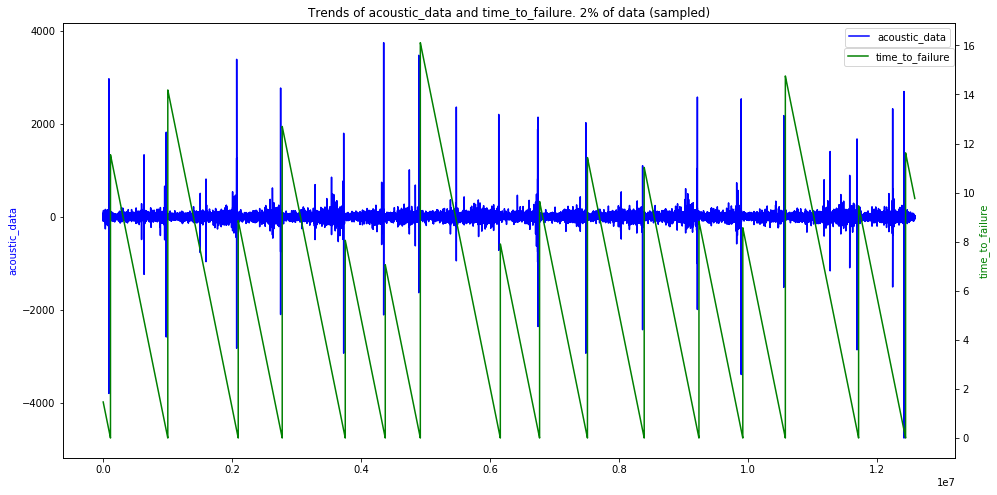

In [5]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

- We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
- Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;
- I thought that comparing max values of signal in a segment to some threshold value (1000 or 2000) could be useful, but it didn't work;

## Feature generation
I create several groups of features:

- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [6]:
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

In [7]:
X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [8]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

In [9]:
def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [10]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [11]:
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['acoustic_data'].values)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    # rdg: mean_change_abs corrected
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.abs(np.diff(xc)))
    X.loc[seg_id, 'mean_change_rate'] = calc_change_rate(xc)
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = calc_change_rate(xc[:50000])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = calc_change_rate(xc[-50000:])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = calc_change_rate(xc[:10000])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = calc_change_rate(xc[-10000:])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta(xc, 50, 1000).mean()
    X.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta(xc, 100, 5000).mean()
    X.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta(xc, 333, 666).mean()
    X.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta(xc, 4000, 10000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    # TODO: why 6000 instead of 30000
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 3
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    X.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc, 0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc, 0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)

    # rdg: The frequency features are new
    X.loc[seg_id, 'freq_cross_first_50000'] = freq_from_crossings(xc.values[:50000], fs)
    X.loc[seg_id, 'freq_cross_last_50000'] = freq_from_crossings(xc.values[-50000:], fs)
    X.loc[seg_id, 'freq_cross_first_10000'] = freq_from_crossings(xc.values[:10000], fs)
    X.loc[seg_id, 'freq_cross_last_10000'] = freq_from_crossings(xc.values[-10000:], fs)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_std)))
        # rdg: TODO - use function calc_change_rate
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.abs(np.diff(x_roll_mean)))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [14]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, X_tr)
    y_tr.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

HBox(children=(IntProgress(value=0, max=4194), HTML(value='')))

In [15]:
print(f'{X_tr.shape[0]} samples in new train data and {X_tr.shape[1]} columns.')

4194 samples in new train data and 142 columns.


## On sampling

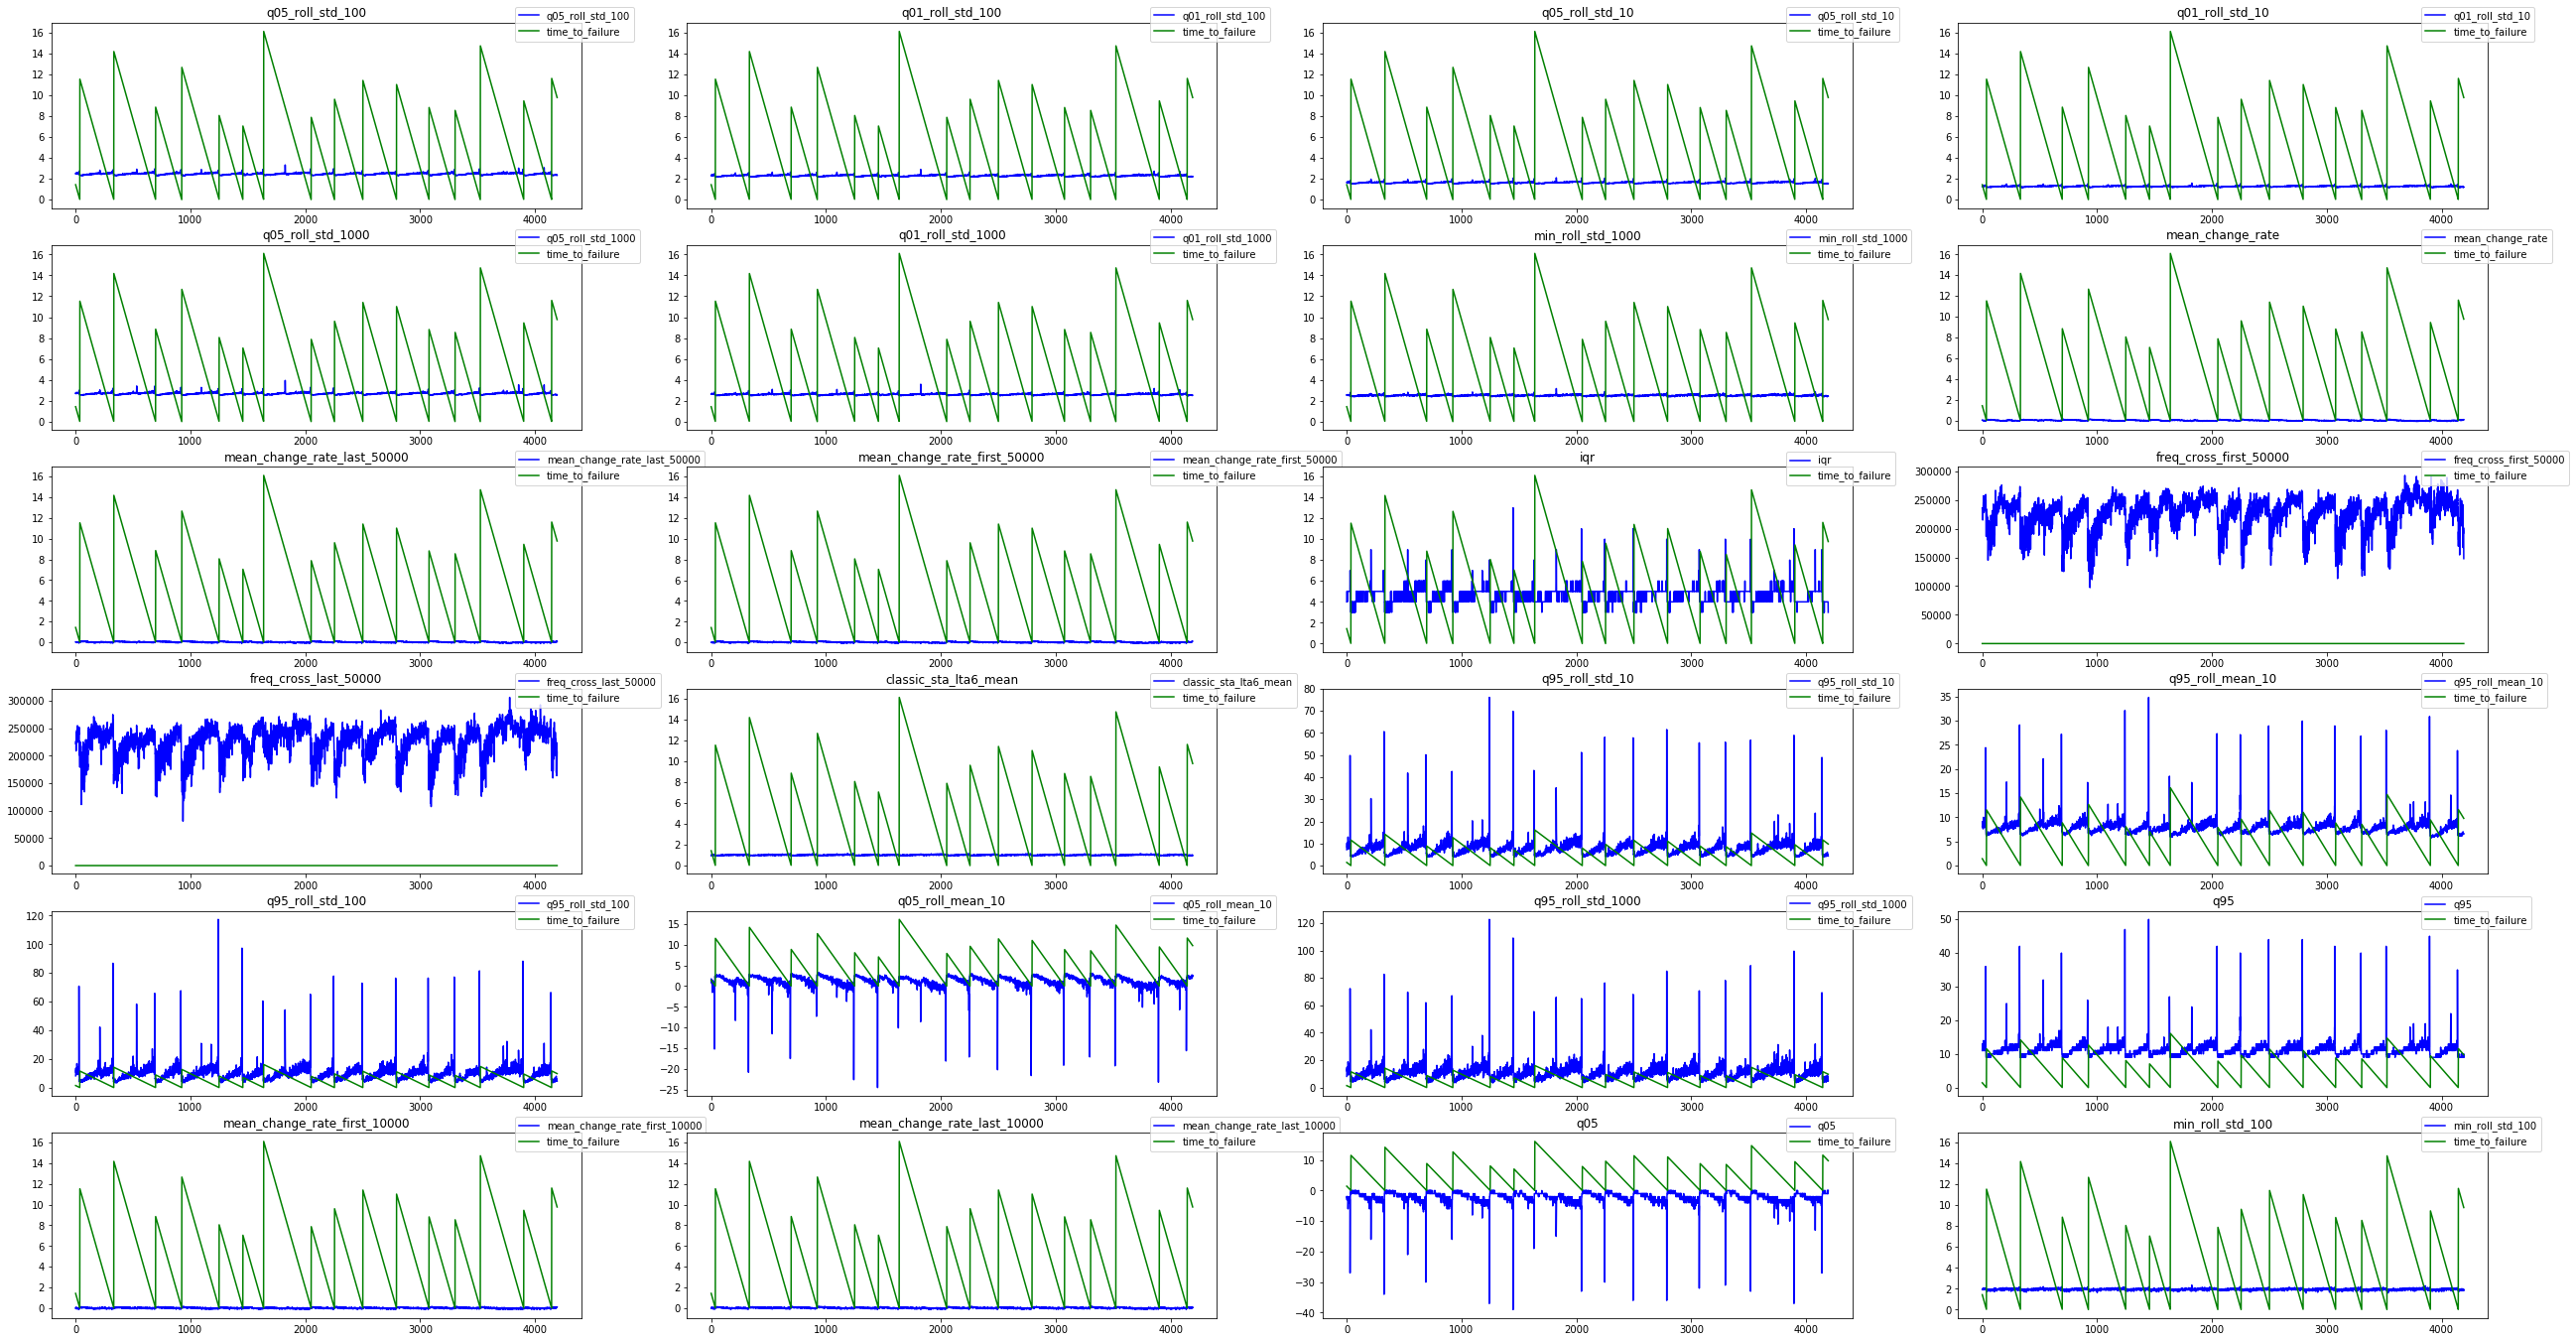

In [16]:
plt.subplots(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(6, 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [17]:
means_dict = {}
for col in X_tr.columns:
    if X_tr[col].isnull().any():
        print(col)
        mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
        X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
        X_tr[col] = X_tr[col].fillna(mean_value)
        means_dict[col] = mean_value

classic_sta_lta5_mean
classic_sta_lta7_mean


In [18]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

## Reading test data

In [19]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)

In [20]:
plt.figure(figsize=(22, 16))
for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

HBox(children=(IntProgress(value=0, max=2624), HTML(value='')))

<Figure size 1584x1152 with 0 Axes>

In [21]:
# rdg: TODO - filling like this the empty spots is questionable
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

In [22]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [23]:
X_tr.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,4.884113333333334,5.101106130606765,104.0,-98.0,2.613217421449476,0.036138006830485,104.0,0.0,6.488551888989741,3.664663420228340,...,0.295714650592636,5.629,3.896,4.072,4.379,5.338,5.484,0.004835288590604,74222.343442640820285,5.629
1,4.725766666666667,6.588823781946801,181.0,-154.0,2.701524676831179,0.022628810812312,181.0,0.0,7.305232697765033,5.493070500263983,...,0.231586699576737,5.667,3.412,4.233,4.345,5.066,5.223,0.005356221476510,74364.426477527638781,5.667
2,4.906393333333333,6.967397033524431,140.0,-106.0,2.792605284035227,0.023744293687586,140.0,0.0,6.104836457315087,8.603695613814120,...,0.267011771793293,5.957,4.055,4.239,4.446,5.344,5.486,0.006040671140940,74594.984584474615986,5.957
3,4.902240000000000,6.922305187180113,197.0,-199.0,2.705618037453583,0.042462106917742,199.0,0.0,6.238109475682244,5.652441899780007,...,0.266699817775971,5.858,3.722,4.304,4.433,5.317,5.453,0.005557248322148,74333.143622613599291,5.858
4,4.908720000000000,7.301110189758817,145.0,-126.0,2.712478083187221,0.038659029321996,145.0,0.0,5.323829516204886,7.694506067635043,...,0.228004751350508,6.078,3.918,4.434,4.543,5.306,5.491,0.005786879194631,74428.435968884237809,6.078


In [24]:
X_test.head()

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.491780000000000,4.893689687028069,115.0,-75.0,2.609324062160415,0.005003246445902,115.0,0.0,5.350451034532767,4.793875620463218,...,0.231890979668247,5.495,3.774,3.889,4.099,4.867,5.000,0.004754087248322,74583.596158882588497,5.495
seg_0012b5,4.171153333333334,5.922839443206628,152.0,-140.0,2.672431149540997,-0.016035706466006,152.0,0.0,6.249515353149148,4.147562311993070,...,0.230913661347393,5.009,3.342,3.644,3.790,4.541,4.739,0.005169295302013,74346.833284796943190,5.009
seg_00184e,4.610260000000000,6.946990077490285,248.0,-193.0,2.692197947986320,0.037691452456924,248.0,0.0,9.793473000415229,5.225913486029075,...,0.247219261166618,6.234,3.544,4.013,4.215,4.966,5.082,0.005249959731544,74349.464458851696691,6.234
seg_003339,4.531473333333333,4.114146602958288,85.0,-93.0,2.516930112867419,0.064438609887591,93.0,0.0,3.664087695508022,3.480839857925289,...,0.224908762860213,5.446,3.889,4.032,4.184,4.911,5.051,0.003891375838926,74430.046482895355439,5.446
seg_0042cc,4.128340000000000,5.797163636220498,177.0,-147.0,2.636957579717198,-0.010527439420553,177.0,0.0,5.321132797542776,7.486142223395909,...,0.274025292743740,5.027,3.357,3.534,3.662,4.570,4.870,0.004879825503356,74545.727161125323619,5.027


## Building models

In [25]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [60]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb',
                model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', task_type = 'GPU', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        return oof, prediction, np.mean(scores), feature_importance
    else:
        return oof, prediction, np.mean(scores)


In [61]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, score_lgb, feature_importance = train_model(params=params, model_type='lgb')

Fold 0 started at Sat Mar  2 22:37:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1235]	training's l1: 1.56442	valid_1's l1: 2.07187
Fold 1 started at Sat Mar  2 22:37:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1410]	training's l1: 1.52028	valid_1's l1: 2.01366
Fold 2 started at Sat Mar  2 22:38:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1077]	training's l1: 1.61331	valid_1's l1: 2.12886
Fold 3 started at Sat Mar  2 22:38:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[975]	training's l1: 1.70378	valid_1's l1: 1.90639
Fold 4 started at Sat Mar  2 22:38:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[865]	training's l1: 1.71918	valid_1's l1: 2.08155
CV mean score: 2.0405, std: 0.0764.


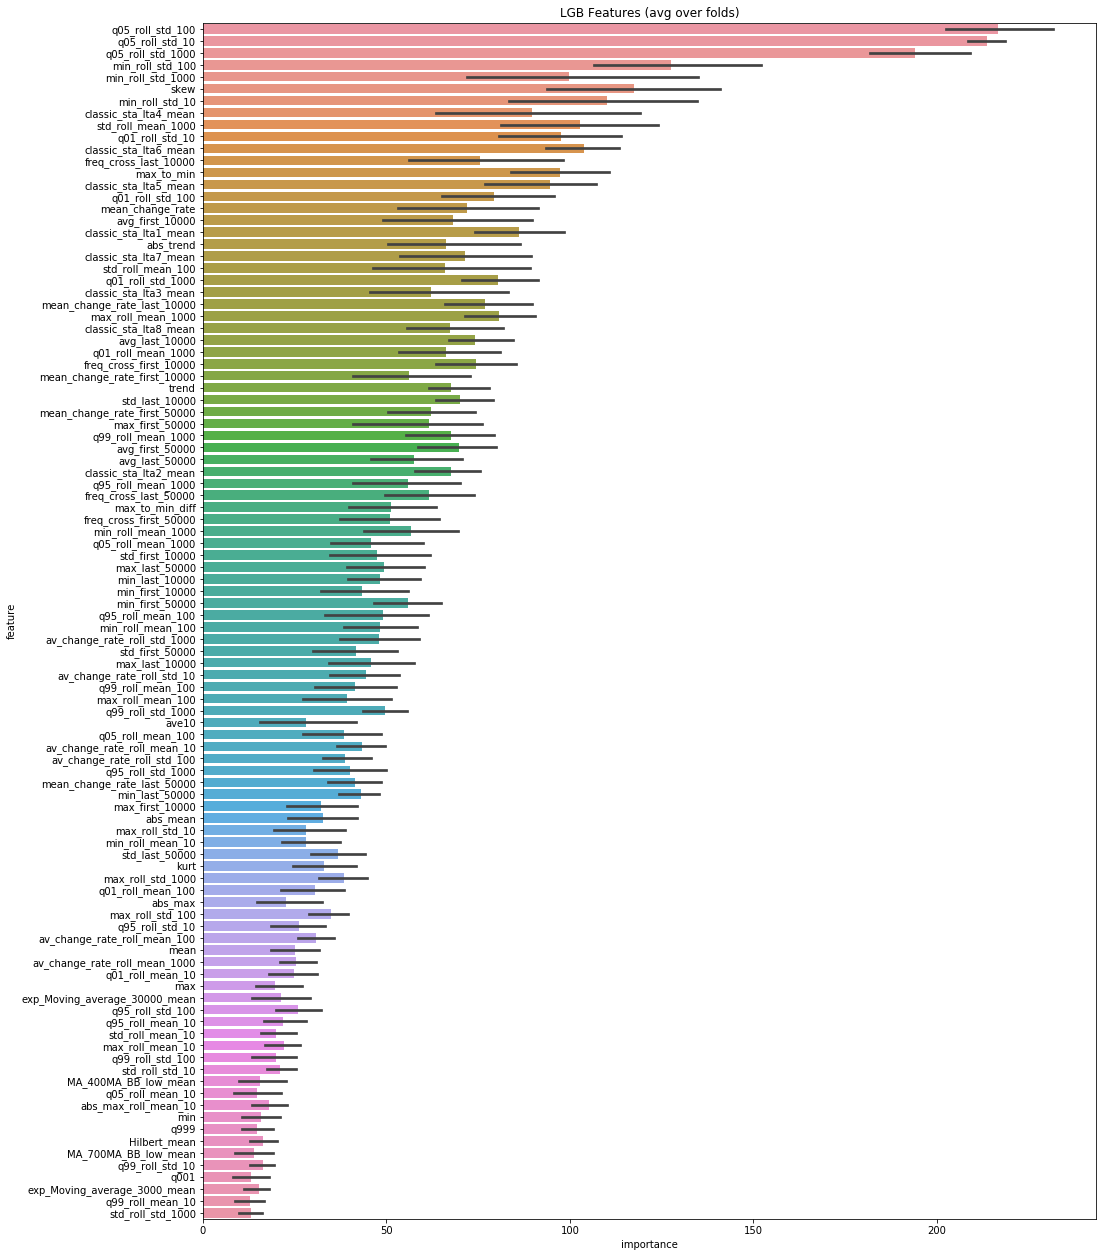

In [62]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:100].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(16, 22));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [63]:
xgb_params = {'eta': 0.05,
              'max_depth': 10,
              'subsample': 0.9,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb, score_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params,
                                                 model_type='xgb')

Fold 0 started at Sat Mar  2 22:38:16 2019
[0]	train-mae:4.93799	valid_data-mae:5.09045
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[55]	train-mae:0.713033	valid_data-mae:2.17448

Fold 1 started at Sat Mar  2 22:38:20 2019
[0]	train-mae:4.96205	valid_data-mae:4.98068
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[62]	train-mae:0.612789	valid_data-mae:2.06703

Fold 2 started at Sat Mar  2 22:38:24 2019
[0]	train-mae:4.95598	valid_data-mae:5.00475
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[60]	train-mae:0.640072	valid_data-mae:2.15319

Fold 3 started at Sat Mar  2 22:38:29 2019
[0]	train

In [64]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr, score_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None,
                                                 model_type='sklearn', model=model)

Fold 0 started at Sat Mar  2 22:38:37 2019
Fold 0. MAE: 2.0940.

Fold 1 started at Sat Mar  2 22:38:40 2019
Fold 1. MAE: 2.0510.

Fold 2 started at Sat Mar  2 22:38:43 2019
Fold 2. MAE: 2.1294.

Fold 3 started at Sat Mar  2 22:38:46 2019
Fold 3. MAE: 1.9156.

Fold 4 started at Sat Mar  2 22:38:48 2019
Fold 4. MAE: 2.1191.

CV mean score: 2.0618, std: 0.0780.


In [65]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1, score_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None,
                                        model_type='sklearn', model=model)

Fold 0 started at Sat Mar  2 22:39:10 2019
Fold 0. MAE: 2.0626.

Fold 1 started at Sat Mar  2 22:39:12 2019
Fold 1. MAE: 2.0239.

Fold 2 started at Sat Mar  2 22:39:14 2019
Fold 2. MAE: 2.1155.

Fold 3 started at Sat Mar  2 22:39:16 2019
Fold 3. MAE: 1.8977.

Fold 4 started at Sat Mar  2 22:39:18 2019
Fold 4. MAE: 2.0763.

CV mean score: 2.0352, std: 0.0747.


In [31]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat, score_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params,
                                                 model_type='cat')

Fold 0 started at Sat Mar  2 22:04:51 2019
Fold 1 started at Sat Mar  2 22:07:45 2019
Fold 2 started at Sat Mar  2 22:10:42 2019
Fold 3 started at Sat Mar  2 22:13:40 2019
Fold 4 started at Sat Mar  2 22:16:35 2019
CV mean score: 2.0249, std: 0.0672.


In [32]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r, score_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None,
                                  model_type='sklearn', model=model)

Fold 0 started at Sat Mar  2 22:19:32 2019
Fold 0. MAE: 2.1612.

Fold 1 started at Sat Mar  2 22:19:33 2019
Fold 1. MAE: 2.1029.

Fold 2 started at Sat Mar  2 22:19:33 2019
Fold 2. MAE: 2.2135.

Fold 3 started at Sat Mar  2 22:19:34 2019
Fold 3. MAE: 1.9923.

Fold 4 started at Sat Mar  2 22:19:35 2019
Fold 4. MAE: 2.2101.

CV mean score: 2.1360, std: 0.0823.


## Stacking and blending
And now let's try stacking :) We can use the same function for it.

In [33]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r,
                        prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

In [66]:
oof_lgb_stack, prediction_lgb_stack, score_stack, feature_importance = train_model(X=train_stack,
                                                                                   X_test=test_stack,
                                                                                   params=params,
                                                                                   model_type='lgb')

Fold 0 started at Sat Mar  2 22:39:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1225]	training's l1: 1.83489	valid_1's l1: 2.07691
Fold 1 started at Sat Mar  2 22:39:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1260]	training's l1: 1.84983	valid_1's l1: 2.01328
Fold 2 started at Sat Mar  2 22:39:30 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[830]	training's l1: 1.87853	valid_1's l1: 2.13254
Fold 3 started at Sat Mar  2 22:39:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1145]	training's l1: 1.88307	valid_1's l1: 1.91307
Fold 4 started at Sat Mar  2 22:39:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1133]	training's l1: 1.84522	valid_1's l1: 2.08074
CV mean score: 2.0433, std: 0.0753.


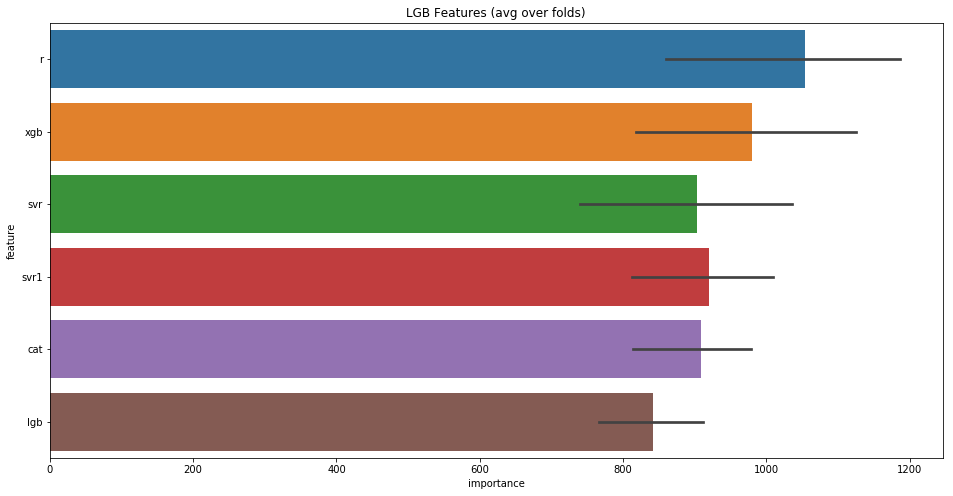

In [69]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False).index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
plt.figure(figsize=(16, 8));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

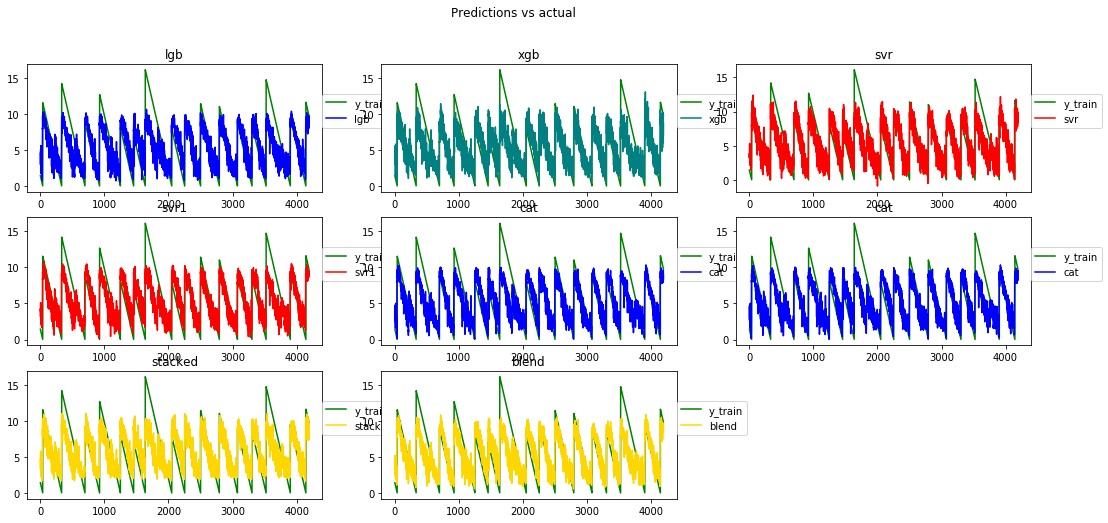

In [35]:
plt.figure(figsize=(18, 8))
plt.subplot(3, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');

plt.subplot(3, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');

plt.subplot(3, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend(loc=(1, 0.5));
plt.title('svr');

plt.subplot(3, 3, 4)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr1, color='red', label='svr1')
plt.legend(loc=(1, 0.5));
plt.title('svr1');

plt.subplot(3, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');

plt.subplot(3, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');

plt.subplot(3, 3, 7)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend(loc=(1, 0.5));
plt.title('stacked');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

plt.subplot(3, 3, 8)
plt.plot(y_tr, color='g', label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_svr1 + oof_r + oof_cat) / 6, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

### Submission - Blend model

In [39]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr +
                                 prediction_svr1 + prediction_cat + prediction_r) / 6
submission.to_csv('../output/submission_rdg_notebook3_blend.csv')
score_blend = (score_lgb + score_xgb + score_svr + score_svr1 + score_cat + score_r) / 6
print(f'CV Score MAE: {score_blend:.4f}.')

CV Score MAE: 2.0665.


### Submission - Stacked model

In [37]:
submission['time_to_failure'] = prediction_lgb_stack
submission.to_csv('../output/submission_rdg_notebook3_stack.csv')
print(f'CV Score MAE: {score_stack:.4f}.')

CV Score MAE: 2.0906.
